In [14]:
%%capture
import pickle
import numpy as np
import math
import scipy as sp
import matplotlib.pyplot as plt
from EM import EM
from plot import plot
from preprocess import preprocess
#from EM_individual_params import EM 

### Modeling choices (which generates the lowest MSE and the plots in write up)
* Cutoff (only consider the data point with at least certain number of observations): 5 --> 2214 data points, 215 bins
* Bin size (length of time interval used to bin the time series): 18 hrs
* Parameters initialization
    * Both treatment and static coefficients: Gaussian with mean 0.1 plus small white noise
* Missingness
    * After binning the data, only consider the data points with less than 40% missing observations
* Chronic conditions and age
    * Set to zero

Coefficients learned with best population level results
* Coefficient for nsaid: [0.31291354 0.11150224 0.02927106]
* Coefficient for transfusion_plasma: [0.21646024 0.12142273 0.07316288]
* Coefficient for transfusion_platelet: [-0.24024057 -0.41378184 -0.28599656]
* Coefficient for anticoagulant: [-0.04605939  0.15568198  0.06412978]
* Coefficient for aspirin: [0.25202486 0.1102651  0.03499285]

Coefficients (jointly) learned with best population level results
* Coefficient for nsaid: [ 0.09144572  0.01808053 -0.00736706]
* Coefficient for transfusion_plasma: [-0.29370552 -0.15658492 -0.12820925]
* Coefficient for transfusion_platelet: [-0.32318352 -0.44511952 -0.43787362]
* Coefficient for anticoagulant: [-0.46557922  0.00142221 -0.02525039]
* Coefficient for aspirin: [-0.04017403 -0.04024049 -0.00733096]
* Coefficient for chronic kidney failure: 0.27480724324859296
* Coefficient for sickle cell: 0.238516267304465
* Coefficient for age: 0.01752724784756275

In [2]:
# Preprocess Setting
bin_size = 60 * 18
cutoff = 5
missing_pct = .4
c_zero = False

# EM Setting
num_past_effects = 3
training_pct = .8
single_effect = False

In [3]:
data = pickle.load(open('../Data/unimputed_inr_patient_data.pkl', 'rb'), encoding='latin1')

In [4]:
y, X, c = preprocess(data, cutoff, bin_size, missing_pct=missing_pct, c_zero=c_zero)

In [5]:
y.shape

(2214, 215)

### Reasons for Errors
* Assume the a single set of parameters generate all the data. This assumption could be violated since:
    1. Each patient respond to treatment differently
    2. Different treatment and chronic conditions may have various interaction effects on different individuals
* After changing treatment coefficients to be on individual level, the average coefficients are similar to the case of population level coefficients. The fit on some plots improve slightly but not much.  
* Assume observed value is well explained by the treatment and chronic variable. whereas in reality there might be other variable that contributes to the observed
* Assume linear transition, emission and treatment/chronic effects
* Seeing from the data, treatments don't seem to show clear effects on INR, from plots and from calculations.

In [6]:
em = EM(y, X, c, num_past_effects, 0, train_pct=training_pct, single_effect=single_effect)

In [7]:
%%time
em.run_EM(2000)

KeyboardInterrupt: 

In [8]:
em.get_MSE()

0.9621069531366008

In [9]:
treatment_types = ['nsaid', 'transfusion_plasma', 'transfusion_platelet', 'anticoagulant', 'aspirin']
for i, treatment in enumerate(treatment_types):
    print('Coefficient for {}: {}'.format(treatment, em.A[:, i]))
static_types = ['chronic kidney failure', 'sickle cell', 'age']
for j, static in enumerate(static_types):
    print('Coefficient for {}: {}'.format(static, em.b[j]))

Coefficient for nsaid: [-0.00915995  0.05411885 -0.00473207]
Coefficient for transfusion_plasma: [-0.45259225 -0.19518185 -0.21680148]
Coefficient for transfusion_platelet: [-0.62202433 -0.78445201 -0.75349439]
Coefficient for anticoagulant: [-0.80657062 -0.05131386 -0.06903811]
Coefficient for aspirin: [-0.03041205  0.00046804  0.11303651]
Coefficient for chronic kidney failure: -0.11908926653975148
Coefficient for sickle cell: -0.4787413515625622
Coefficient for age: -0.01834615312930628


In [10]:
random_patients = np.random.randint(0, y.shape[0], 0)
for i in random_patients:
    plot(em, i, bin_size=bin_size)

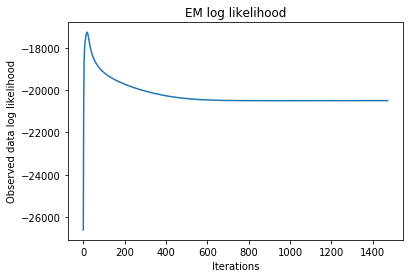

In [15]:
plt.plot([i for i in range(len(em.log_lik))], em.log_lik)
plt.xlabel('Iterations')
plt.ylabel('Observed data log likelihood')
plt.title('EM log likelihood')
plt.show()